In [1]:
import einops
import hydra
import os
import torch
import torch.nn.functional as F
from omegaconf import OmegaConf
from PIL import Image
from safetensors.torch import load_file
from torchvision.transforms.functional import to_tensor

import sys
sys.path.append('..')

In [2]:
# LOAD OUR MODEL
config_dir = "../configs"
cfg_model = OmegaConf.load(os.path.join(config_dir, 'sd21_feature_extractor.yaml'))['model']
print("Loaded config successfully")
cfg_model = hydra.utils.instantiate(cfg_model)
print("Instantiated model successfully")
model = cfg_model.cuda().bfloat16()

# LOAD WEIGHTS (FROM HF)

from huggingface_hub import hf_hub_download
ckpt_pth = hf_hub_download(repo_id="CompVis/cleandift", filename="cleandift_sd21_full.safetensors")
print(f"Downloaded weights file saved at: {ckpt_pth}")
state_dict = load_file(ckpt_pth)
model.load_state_dict(state_dict, strict=True)
model = model.eval()

Loaded config successfully


/export/home/ra48gaq/anaconda3/envs/cleandift/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Instantiated model successfully
Downloaded weights file saved at: /export/home/ra48gaq/.cache/huggingface/hub/models--CompVis--cleandift/snapshots/2a91b40688143811c814fd52c5024fffbd079420/cleandift_sd21_full.safetensors


In [3]:
# LOAD INPUT IMAGES

img_source = Image.open("./example_images/2008_004188.jpg")
img_target = Image.open("./example_images/2007_009889.jpg")

IMAGE_SIZE = (768, 768)

img_source_tensor = to_tensor(img_source.resize(IMAGE_SIZE))[None].to('cuda') * 2 - 1
img_target_tensor = to_tensor(img_target.resize(IMAGE_SIZE))[None].to('cuda') * 2 - 1

# GET FEATURES FOR BOTH IMAGES

caption = f"A photo of a dog"
feat_key = "us6"
print(f"Using feature {feat_key}")

with torch.no_grad():
    source_features = model.get_features(img_source_tensor.bfloat16(), [caption], t=None, feat_key=feat_key)
    print("Got features for source image")
    target_features = model.get_features(img_target_tensor.bfloat16(), [caption], t=None, feat_key=feat_key)
    print("Got features for target image")


Using feature us6
Got features for source image
Got features for target image


In [4]:
# FIND CORRESPONDENCES FOR PROVIDED SOURCE POINTS IN FIRST IMAGE

source_points =  [[122, 200], [125, 283], [186, 287], [177, 229], [136, 206]]

source_features_upsampled = F.interpolate(source_features, tuple(reversed(img_source.size)), mode="bilinear")
target_features_upsampled = F.interpolate(target_features, tuple(reversed(img_target.size)), mode="bilinear")

source_points = torch.tensor(source_points).to(source_features.device).long()
source_point_feats = source_features_upsampled[0, :, source_points[:, 1], source_points[:, 0]].T[:, None]
target_features_upsampled_norm_flat = einops.rearrange(target_features_upsampled / target_features_upsampled.norm(p=2, dim=1, keepdim=True), '1 c h w -> c (h w)')
source_point_feats_norm = source_point_feats / source_point_feats.norm(p=2, dim=-1, keepdim=True)
target_feat_sims = einops.rearrange(source_point_feats_norm @ target_features_upsampled_norm_flat, 'b 1 (h w) -> b h w', h=target_features_upsampled.shape[-2])
matches = torch.stack(torch.unravel_index(einops.rearrange(target_feat_sims, "b h w -> b (h w)").argmax(dim=-1), target_feat_sims.shape[1:])).T

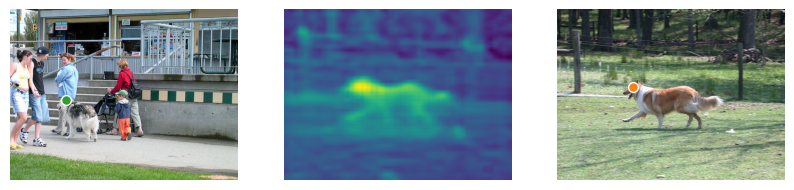

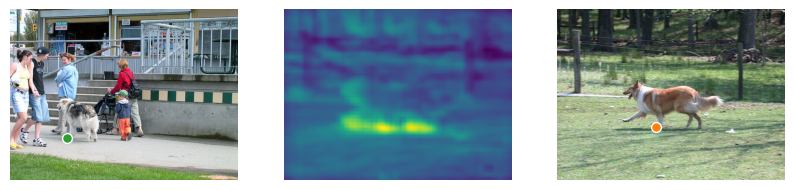

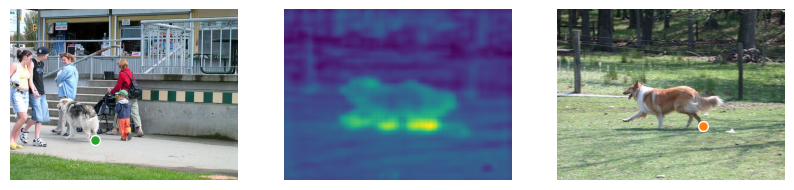

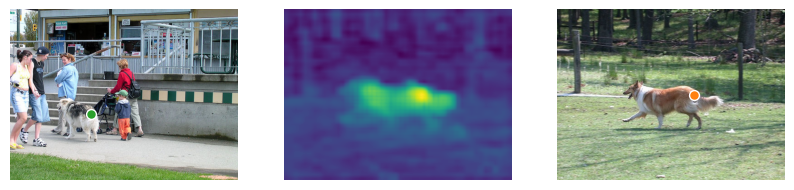

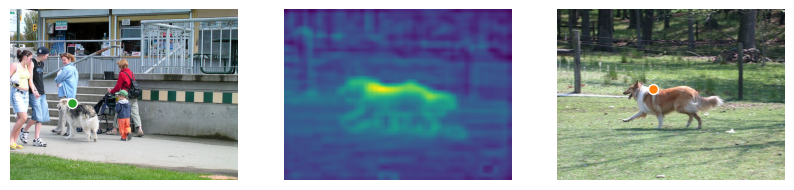

In [5]:
import matplotlib.pyplot as plt

# PLOT RESULTS
for pt_idx in range(len(source_points)):
    plt.figure(figsize=(10,5))
    plt.subplot(131)
    plt.imshow(img_source)
    plt.scatter(*source_points.squeeze().tolist()[pt_idx], edgecolor='white', linewidth=1, color='C2', s=50)
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(target_feat_sims[pt_idx].cpu().float())
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(img_target)
    plt.scatter(*matches[pt_idx].flip(-1).float().cpu().squeeze().tolist(), edgecolor='white', linewidth=1, color='C1', s=50)
    plt.axis('off')
    plt.show()
